In [ ]:
## Part 1
- Overview
- Demo
- Model overview
- Preloaded model & tokenizer
- Quick test

## Part 2
- Update model
- Load dataset
- Data formatting loader

## Part 3
- Training
- Testing
- Recreate demo

# Download Modules

In [1]:
# !pip install transformers sentencepiece datasets

In [2]:
from datasets import load_dataset
# from google.colab import drive
# from IPython.display import display
# from IPython.html import widgets
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import os
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig, AutoModel
from transformers import get_linear_schedule_with_warmup
!jupyter nbextension enable --py widgetsnbextension
from tqdm import notebook
import pandas as pd
import glob2
sns.set()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# drive.mount('/content/gdrive')

In [4]:
model_repo = 'alirezamsh/small100'
model_path = './model/small100_no_pretrained.pt'
model_folder = './model/'
max_seq_len = 128

# Load Tokenizer & Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo, max_new_tokens = max_seq_len)

In [6]:
# Model description: https://huggingface.co/google/mt5-base
config = AutoConfig.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_config(config)
model = model.cuda()


# Overview and Quick Test

In [7]:
token_ids = tokenizer.encode(
    '<lo> This will be translated to Laos! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids, max_new_tokens = max_seq_len)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[128022,   5966,    704,   3473,  36606,  13635,    667,   5815,   2791,
            241,    128,    343,     63,     30,     11,  34023, 120433,   2247,
             17,      2]], device='cuda:0')
tensor([[     2, 105924, 105924, 105924, 105924, 105924, 105924, 105924, 105924,
         105924, 105924, 105924, 105924, 105924, 105924,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,
          23028,  23028,  23028,  23028,  23028,  23028,  23028,  23028,  87330,
          87330,  87330,  87330,  87330,  87330,  87330,  87330,  87330,  87330,
          87330,  87330,  87330,  87330,  87330,  87330,  87330, 

# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [8]:
example_input_str = '<lo> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[128022,   5966,    704,   3473,  36606,    117,   6286,      8,   4183,
            136,   1450,    297,      5,      2]])
Tokens: ['__en__', '▁<', 'lo', '>', '▁This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>']


In [9]:
# sorted(tokenizer[], key=lambda x: x[1])
# len(tokenizer.vocab.items())

# Prepare Dataset

## Duolingual Dataset

In [10]:
import glob2
lo_train_filenames = sorted(glob2.glob('./data/train/Nhattan/split/train/*.lo'))
vi_train_filenames = sorted(glob2.glob('./data/train/Nhattan/split/train/*.vi'))
print(lo_train_filenames)
print(vi_train_filenames)
lo_val_filenames = sorted(glob2.glob('./data/train/Nhattan/split/val/*.lo'))
vi_val_filenames = sorted(glob2.glob('./data/train/Nhattan/split/val/*.vi'))
print(lo_val_filenames)
print(vi_val_filenames)

['./data/train/Nhattan/split/train/split_train2023_combine0to40k_basicPreprocessed.lo', './data/train/Nhattan/split/train/split_train2023_combine40kto100k_basicPreprocessed.lo']
['./data/train/Nhattan/split/train/split_train2023_combine0to40k_basicPreprocessed.vi', './data/train/Nhattan/split/train/split_train2023_combine40kto100k_basicPreprocessed.vi']
['./data/train/Nhattan/split/val/split_val2023_0to10k.lo', './data/train/Nhattan/split/val/split_val2023_10kto30k.lo', './data/train/Nhattan/split/val/split_val2023_40kto100k.lo']
['./data/train/Nhattan/split/val/split_val2023_0to10k.vi', './data/train/Nhattan/split/val/split_val2023_10kto30k.vi', './data/train/Nhattan/split/val/split_val2023_40kto100k.vi']


In [11]:
from datasets import load_dataset, Dataset
lo_train_dataset = load_dataset("text", data_files=lo_train_filenames)
vi_train_dataset = load_dataset("text", data_files=vi_train_filenames)
lo_test_dataset = load_dataset("text", data_files=lo_val_filenames)
vi_test_dataset = load_dataset("text", data_files=vi_val_filenames)

Using custom data configuration default-f4a65be3625ba821
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-f4a65be3625ba821/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-643804beb805be1a
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-643804beb805be1a/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-0d944f7a98975e76
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-0d944f7a98975e76/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f4ec4dbc6f73d858
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-f4ec4dbc6f73d858/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
lo_train_dataset = lo_train_dataset["train"]['text']
vi_train_dataset = vi_train_dataset["train"]['text']
lo_test_dataset = lo_test_dataset["train"]['text']
vi_test_dataset = vi_test_dataset["train"]['text']

In [13]:
train_dataset = Dataset.from_dict({"translation": Dataset.from_dict({"lo": lo_train_dataset, "vi": vi_train_dataset})})
test_dataset = Dataset.from_dict({"translation": Dataset.from_dict({"lo": lo_test_dataset, "vi": vi_test_dataset})})
# import pandas as pd
# train_dataset = pd.DataFrame(train_dataset['translation']).to_dict(orient="records")
# test_dataset = pd.DataFrame(test_dataset['translation']).to_dict(orient="records")
# train_dataset = Dataset(train_dataset)
# test_dataset = Dataset(test_dataset)

In [14]:
train_dataset['translation'][0:9]

[{'lo': 'ໃນ ຂໍ້ ທີ 33 ເຮົາ ອ່ານ ກ່ຽວ ກັບ ຜູ້ ຄົນ ທີ່ ຕອບ ຮັບອີກ ແບບ ຫນຶ່ງ ກັບ ສຽງຫົວຂວັນ ແລະ ຄໍາ ເຍາະ ເຍີ້ຍ ທີ່ ພວກ ເຂົາ ໄດ້ ຍິນ ຈາກ ອາຄານ ຫລັງນັ້ນ.',
  'vi': 'Trong câu 33 chúng ta đọc về những người đã có phản ứng khác nhau đối với lời nhạo báng và chế nhạo đến từ tòa nhà.'},
 {'lo': 'ສະນັ້ນ ເພິ່ນ ຈຶ່ງ ພະຍາຍາມ ຈົນ ສຸດ ຄວາມ ສາມາດ ເພື່ອ ຈະ ໄດ້ ສະ ແດງ ຄວາມ ສໍາ ເລັດ ຜົນຂອງ ປະ ເທດ.',
  'vi': 'Và do đó, ông đã bỏ ra hết nỗ lực để phô trương những thành tựu của đất nước đó.'},
 {'lo': '15 ຈົ່ງ ເບິ່ງ, ພວກ ເຂົາ ຈະ ຮ່ວມ ກັນ ຕໍ່ສູ້ ເຈົ້າຢ່າງ ແນ່ນອນ, ແຕ່ ບໍ່ ແມ່ນ ໂດຍ ເຮົາ; ຜູ້ ໃດກໍ ຕາມ ທີ່ ຈະ ຮ່ວມ ກັນ ຕໍ່ຕ້ານ ເຈົ້າ ກໍ ຈະລົ້ມລົງ.',
  'vi': '15 Này, chắc chắn sẽ có kẻ tụ họp lập mưu hại ngươi, nhưng việc đó chẳng phải do ta; bất cứ kẻ nào tụ tập nhau lại để hại ngươi cũng sẽ ngã xuống vì cớ ngươi.'},
 {'lo': 'ລະຫວ່າງ ສອງ ປີຜ່ານມາ ນີ້, ໂດຍ ທີ່ ພວກ ເຮົາ ພະຍາຍາມ ເອົາໃຈໃສ່ ກັບ ການ ສ້າງ ພຣະ ວິຫານ ທີ່ ໄດ້ປະກາດ ໄປ ໃຫ້ ສໍາເລັດ, ພວກ ເຮົາ ໄດ້ ງົດ ແຜນທີ່ ຈະ ປະກາດ ພຣະ ວິຫານ ທີ່ ຈະ ສ້າງ ເພີ່ມ ເຕີມ.',
  'vi': '

## Monolingual Data

In [15]:
LAO_MONO_PATH = '../monolingual data/lo.txt'
VI_MONO_PATH = '..//monolingual data/vi.txt'

In [16]:
lo_mono_dataset = load_dataset("text", data_files=LAO_MONO_PATH)
vi_mono_dataset = load_dataset("text", data_files=VI_MONO_PATH)



Using custom data configuration default-0c6cca86e6e28638


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/comrade/.cache/huggingface/datasets/text/default-0c6cca86e6e28638/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-71ef9d195a744dc8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/comrade/.cache/huggingface/datasets/text/default-71ef9d195a744dc8/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
lo_mono_dataset = lo_mono_dataset['train']['text']
vi_mono_dataset = vi_mono_dataset['train']['text']

In [19]:
mono_dataset = Dataset.from_dict({"lo": lo_train_dataset, "vi": vi_train_dataset})

In [ ]:
mono_dataset

## Data Transform

In [ ]:
# LANG_TOKEN_MAPPING = {
#     'vi': '<vi>',
#     'lo': '<lo>'
# }
tokenizer.src_lang = "vi"
tokenizer.tgt_lang = "lo"
sampleInputSentence = 'Phiên dịch tiếng Lào: câu này sẽ được dịch thành tiếng Lào.'
sampleOutputSentence = 'ການ​ແປ​ພາ​ສາ​ລາວ​: ປະ​ໂຫຍກ​ນີ້​ຈະ​ຖືກ​ແປ​ເປັນ​ພາ​ສາ​ລາວ​.'

tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)
print(tokenizerOutput['input_ids'])
print(tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0]))
print(tokenizer.decode(tokenizerOutput['input_ids'][0]))

model.eval()
modelOutput = model(tokenizerOutput['input_ids'],
                    attention_mask = tokenizerOutput['attention_mask'],
                    labels = tokenizerOutput['labels'])

modelGenerate = model.generate(tokenizerOutput['input_ids'], max_new_tokens = max_seq_len, forced_bos_token_id=tokenizer.get_lang_id("lo"))
print(modelGenerate)

output_text = tokenizer.decode(modelGenerate[0])
print(tokenizer.convert_ids_to_tokens(modelGenerate[0]))
print(output_text)

In [ ]:
tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)

tokens = tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0])
print(tokens) # Make sure that the special translation token is not 'fragmented'

In [ ]:
# special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
# tokenizer.add_special_tokens(special_tokens_dict)
# model.resize_token_embeddings(len(tokenizer))

In [ ]:
# torch.save(model, model_path)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

In [ ]:
def encode_str(text, text_target, tokenizer, seq_len):

    # Tokenize and add special tokens
    tokenizerOutp = tokenizer(
        text = text,
        text_target = text_target,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = seq_len).to(device)

    return tokenizerOutp['input_ids'][0], tokenizerOutp['labels'][0], tokenizerOutp['attention_mask'][0]


def format_translation_data(translations, tokenizer, seq_len=max_seq_len, input_lang = None, target_lang = None):
    if input_lang == None and target_lang = None:
        # Choose a random 2 languages for in i/o
        input_lang, target_lang = np.random.choice(['vi', 'lo'], size = 2, replace = False)
    
    # Get the translations for the batch
    input_text = translations[input_lang]
    target_text = translations[target_lang]

    if input_text is None or target_text is None:
        return None
    
    if ((input_lang == 'lo') & (target_lang == 'vi')):
        tokenizer.src_lang = "lo"
        tokenizer.tgt_lang = "vi"
    elif ((input_lang == 'vi') & (target_lang == 'lo')):
        tokenizer.src_lang = "vi"
        tokenizer.tgt_lang = "lo"
    else:
        print('WARNING: SOMETHING WRONG WHEN RANDOMIZING LANG')

    input_token_ids, target_token_ids, attention_mask = encode_str(
        input_text, target_text, tokenizer, seq_len)

    return input_token_ids, target_token_ids, attention_mask


def transform_batch(batch, tokenizer, input_lang=None, target_lang=None):
    inputs = []
    targets = []
    attentionMask = []
    for translation_set in batch['translation']:
        formatted_data = format_translation_data(
            translation_set, tokenizer, max_seq_len, input_lang = None, target_lang=None)

        if formatted_data is None:
            continue

        input_ids, target_ids, attention_mask = formatted_data

        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))
        attentionMask.append(attention_mask.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()
    attentionMask = torch.cat(attentionMask).cuda()

    return batch_input_ids, batch_target_ids, attentionMask


def get_data_generator(dataset, tokenizer, batch_size = 32, input_lang=None, target_lang = None):
    dataset = dataset.shuffle()
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_batch(raw_batch, tokenizer, input_lang = None, target_lang = None)

In [ ]:
# Testing `data_transform`
in_ids, out_ids, attention_mask = format_translation_data(
    train_dataset[0]['translation'], tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)
print('Attention mask shape:', data_batch[2].shape)

## Self Supervised and Backtranslation Data Generate

In [53]:
def encode_str(text, tokenizer, seq_len):
    # Tokenize and add special tokens
    tokenizerOutp = tokenizer(
        text = text,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = seq_len).to(device)

    return tokenizerOutp['input_ids'][0], tokenizerOutp['attention_mask'][0]


def format_aug_translation_data(translations, tokenizer, seq_len=max_seq_len, input_lang = None, target_lang = None):
    if input_lang == None and target_lang == None:
        # Choose a random 2 languages for in i/o
        input_lang, target_lang = np.random.choice(['vi', 'lo'], size = 2, replace = False)
    
    # Get the translations for the batch
    input_text = translations[input_lang]

    if input_text is None:
        return None
    
    if ((input_lang == 'lo') & (target_lang == 'vi')):
        tokenizer.src_lang = "lo"
        tokenizer.tgt_lang = "vi"
    elif ((input_lang == 'vi') & (target_lang == 'lo')):
        tokenizer.src_lang = "vi"
        tokenizer.tgt_lang = "lo"
    else:
        print('WARNING: SOMETHING WRONG WHEN RANDOMIZING LANG')

    input_token_ids, attention_mask = encode_str(
        input_text, tokenizer, seq_len)

    return input_token_ids, attention_mask


def transform_aug_batch(batch, tokenizer, input_lang=None, target_lang=None):
    inputs = []
    targets = []
    attentionMask = []
    for translation_set in batch['translation']:
        formatted_data = format_aug_translation_data(
            translation_set, tokenizer, max_seq_len, input_lang = None, target_lang=None)

        if formatted_data is None:
            continue

        input_ids, attention_mask = formatted_data

        inputs.append(input_ids.unsqueeze(0))
        attentionMask.append(attention_mask.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    attentionMask = torch.cat(attentionMask).cuda()

    return batch_input_ids, attentionMask


def get_aug_data_generator(dataset, tokenizer, batch_size = 32, input_lang=None, target_lang = None):
    dataset = dataset.shuffle()
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_aug_batch(raw_batch, tokenizer, input_lang = None, target_lang = None)

In [54]:
def generate_str(input_ids,target_lang):
    output_tokens = model.generate(input_ids, num_return_sequences=1, max_new_tokens = max_seq_len)
    return tokenizer.decode(output_tokens, skip_special_tokens=True)

def create_augment_dataList(model, tokenizer, mono_dataset, input_lang = 'lo', target_lang = 'vi'):

    augment_generator = get_aug_data_generator(mono_dataset, input_lang, target_lang, tokenizer, batch_size = 4)
    outputSentenceListLoVi = []

    for i, (input_batch, label_batch, attention_mask_batch) in enumerate(test_generator):
        outpSentenceLoVi = model.generate(input_batch, num_beams = 1, num_return_sequences=1, max_new_tokens = max_seq_len, forced_bos_token_id = tokenizer.get_lang_id(target_lang))
        outpSentenceLoVi = tokenizer.batch_decode(outpSentenceLoVi, skip_special_tokens = True)
        outputSentenceListLoVi = outputSentenceListLoVi + outpSentenceLoVi
    
    return outputSentenceList

def create_augment_dataset(model, tokenizer, mono_dataset, input_lang = 'lo', target_lang = 'vi'):
    augment_list = create_augment_dataList(model, tokenizer, mono_dataset, input_lang, target_lang)
    augment_dataset = Dataset.from_dict({input_lang: mono_dataset[input_lang], target_lang: augment[target_lang]})
    return augment_dataset

In [56]:
# Testing `data_transform`
in_ids, attention_mask = format_aug_translation_data(
    mono_dataset[0], tokenizer, input_lang = 'vi', target_lang = 'lo')

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
# print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_aug_data_generator(train_dataset, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Attention mask shape:', data_batch[1].shape)

__vi__ ▁Trong ▁câu ▁33 ▁chúng ▁ta ▁đọc ▁về ▁những ▁người ▁đã ▁có ▁phản ▁ứng ▁khác ▁nhau ▁đối ▁với ▁lời ▁nh ạo ▁b áng ▁và ▁chế ▁nh ạo ▁đến ▁từ ▁tòa ▁nhà . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input shape: torch.Size([8, 128])
Attention mask shape: torch.Size([8, 128])


# Train/Finetune

In [22]:
# model.load_state_dict(torch.load(model_path), strict=False)

In [23]:
# Constants
n_epochs = 20
# batch_size = 16
batch_size = 24
print_freq = 100
checkpoint_freq = 400
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [24]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [25]:
losses = []

In [26]:
def eval_model(model, gdataset, max_iters = 16):
    
    model.eval()
    test_generator = get_data_generator(gdataset,
                                      tokenizer, batch_size)
    eval_losses = []
    for i, (input_batch, label_batch, attention_mask_batch) in enumerate(test_generator):
        if i >= max_iters:
            break
    
        model_out = model(
            input_ids = input_batch,
            labels = label_batch,
            attention_mask = attention_mask_batch)
        eval_losses.append(model_out.loss.item())
    
    return np.mean(eval_losses)

def train_epoch(model, train_dataset, input_lang, target_lang,epoch_idx, lr):
    # Randomize data order
  data_generator = get_data_generator(train_dataset,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch, attention_mask_batch) \
      in notebook.tqdm(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

In [26]:
for epoch_idx in range(n_epochs):
    train_epoch(train_dataset, model, input_lang='lo', target_lang = 'vi',epoch_idx, lr=learning_rate)
    # train_epoch(mono_dataset_backtranslation)
    # train_epoch(mono_dataset_selfsupervised)
    
    
    if (epoch + 1) % aug_freq == 0:
        mono_lo = create_aug_data()
        mono_vi = create_aug_data()

        # create new augmented dataset and update
        back_translate = Datadict({'lo': create_augment_dataList(model, tokenizer, mono_dataset, input_lang = 'vi', target_lang = 'lo'), 'vi': mono_dataset['vi']})
        semi_supervised= Datadict({'lo': mono_lo, 'vi': create_augment_dataList(model, tokenizer, mono_dataset, input_lang = 'lo', target_lang = 'vi')})
torch.save(model.state_dict(), model_path)
torch.save(model.state_dict(), model_path)

NameError: name 'n_epochs' is not defined

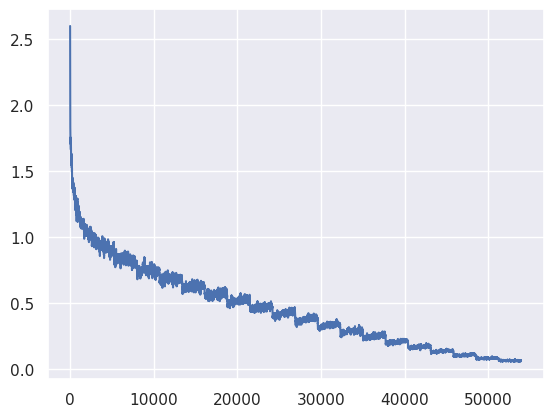

In [28]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [32]:
# test_sentence = test_dataset[0]['translation']['vi']
# print('Raw input text:', test_sentence)

# input_ids = encode_str(
#     text = test_sentence,
#     text_target = 'lo',
#     tokenizer = tokenizer,
#     # seq_len = model.config.max_length,
#     seq_len = max_seq_len,
# )
# input_ids = input_ids.unsqueeze(0).cuda()

# print('Truncated input text:', tokenizer.convert_tokens_to_string(
#     tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Trái đất được thiết kế như một ngôi nhà sạch sẽ cho nhân loại.


AttributeError: 'tuple' object has no attribute 'unsqueeze'

In [33]:
testSrc = 'lo'
testTgt = 'vi'
test_sentence = test_dataset[0]['translation'][testSrc]
test_sentence_target = test_dataset[0]['translation'][testTgt]
print('Raw input text:', test_sentence)

tokenizer.src_lang = testSrc
tokenizer.tgt_lang = testTgt
input_ids, _, _ = encode_str(
    text = test_sentence,
    text_target = test_sentence_target,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: (ໂລມ 1:20) ຫນ່ວຍ ໂລກ ຖືກ ອອກ ແບບ ມາ ເພື່ອ ເປັນ ບ້ານ ທີ່ ສະອາດ ສໍາລັບ ມະນຸດ.
Truncated input text: __lo__ (ໂລມ 1:20) ຫນ່ວຍ ໂລກ ຖືກ ອອກ ແບບ ມາ ເພື່ອ ເປັນ ບ້ານ ທີ່ ສະອາດ ສໍາລັບ ມະນຸດ.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [ ]:
# output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens = max_seq_len)
# # print(output_tokens)
# for token_set in output_tokens:
#   print(tokenizer.decode(token_set, skip_special_tokens=True))

In [34]:


output_tokens = model.generate(input_ids, num_beams = 20, num_return_sequences=3, max_new_tokens = max_seq_len, forced_bos_token_id = tokenizer.get_lang_id(testTgt))
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))





































(bao gồm cả đêm và tiếp tục dậy cho đến khi trở về, điều đó có thể được coi là một ngôi làng dường.
(bao gồm 4bao gồm cả ở trên địa bàn ở bất cứ nơi đâu trên thế giới, bản thân về thể thao, bất kể chi tiết nào.
(bao gồm 4bao gồm cả ở trên địa bàn ở bất cứ nơi đâu trên thế giới, bản thân về thể thao, bất kể họ có thể lãng phí.


In [ ]:
#@title Slick Blue Translate
input_text = 'một người lướt sóng gặp phải cá mập' #@param {type:"string"}
output_language = 'lo' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2, max_new_tokens = max_seq_len)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))